In [63]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [64]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

In [65]:
data = pd.read_csv('data/data.csv')
data = data[data.shot_made_flag.notnull()].reset_index()

In [172]:
def calculate_shot_accuracy(feature):
    results = pd.crosstab(data.shot_made_flag, data[feature]).apply(
        lambda x: x/x.sum(), axis=0)
    columns = np.array(results.columns)
    values = results.values[1:]*100
    return columns, values[0]

def plot_shot_accuracy(x, y, xlabel):
    ax = sns.barplot(x, y)
    ax.set(xlabel=xlabel, ylabel='Shot Accuracy (%)')
    plt.show()

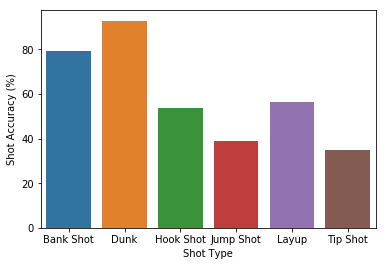

In [173]:
shot_type, accuracy = calculate_shot_accuracy('combined_shot_type')
plot_shot_accuracy(shot_type, accuracy, 'Shot Type')

Text(0.5, 0, 'Accuracy (%)')

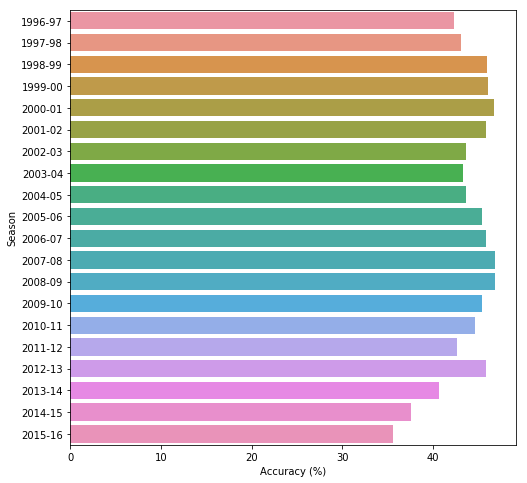

In [178]:
fig = plt.figure(figsize=(8,8))
season, accuracy = calculate_shot_accuracy('season')
df = pd.DataFrame({'Season':season,'Accuracy':accuracy})
ax = sns.barplot(x='Accuracy', y='Season', data=df)
ax.set_xlabel('Accuracy (%)')

Text(0.5, 0, 'Accuracy (%)')

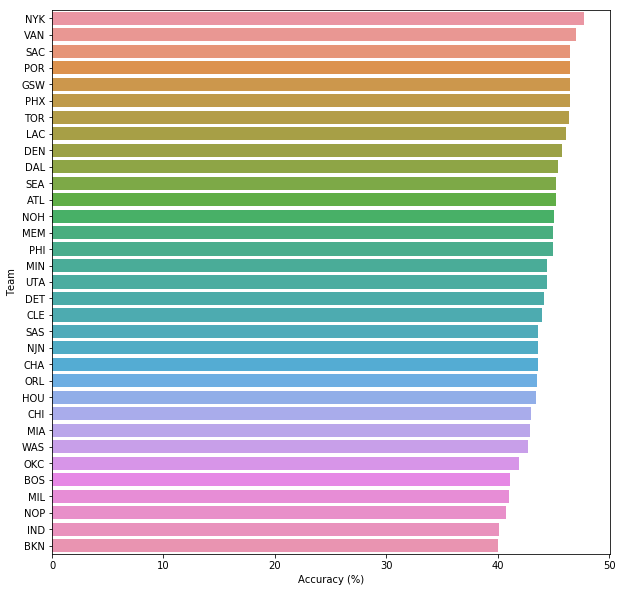

In [181]:
fig = plt.figure(figsize=(10,10))
opponents, accuracy = calculate_shot_accuracy('opponent')
opp, acc = zip(*sorted(list(zip(opponents, accuracy)),
                       key=lambda x: x[1], reverse=True))
df = pd.DataFrame({'Team':list(opp),'Accuracy':list(acc)})
ax = sns.barplot(x='Accuracy', y='Team', data=df)
ax.set_xlabel('Accuracy (%)')

In [72]:
sorted_games = data.copy()
sorted_games = sorted_games.sort_values(['game_date', 'period', 'seconds_remaining'], ascending=[
                                True, True, False]).reset_index(drop=True)

In [73]:
def different_period(row):
    if row.previous_game_date != row.game_date or row.previous_period != row.period:
        return 0
    return row.made_previous_shot

In [74]:
sorted_games['made_previous_shot'] = sorted_games['shot_made_flag'].shift(1).fillna(value=0)
sorted_games['previous_period'] = sorted_games['period'].shift(1).fillna(value=0)
sorted_games['previous_game_date'] = sorted_games['game_date'].shift(1).fillna(value=0)
sorted_games['previous_shot_distance'] = sorted_games['shot_distance'].shift(1).fillna(value=0)
sorted_games['made_previous_shot'] = sorted_games.apply(different_period, axis=1)
sorted_games.drop(columns=['previous_period', 'previous_game_date'], inplace=True)

In [98]:
acc_after_making = sorted_games[sorted_games.made_previous_shot == 1]['shot_made_flag'].mean()*100
acc = sorted_games['shot_made_flag'].mean()*100
acc_after_missing = sorted_games[sorted_games.made_previous_shot == 0]['shot_made_flag'].mean()*100

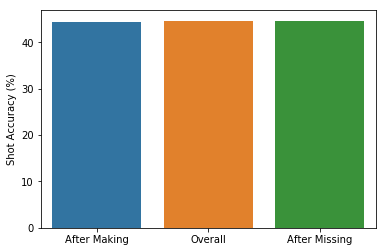

In [99]:
ax = sns.barplot(['After Making', 'Overall', 'After Missing'], [acc_after_making, acc, acc_after_missing])
ax.set(ylabel='Shot Accuracy (%)')
plt.show()

In [90]:
dist_diff_after_missing = (sorted_games[sorted_games.made_previous_shot == 0]['shot_distance'] -
                           sorted_games[sorted_games.made_previous_shot == 0]['previous_shot_distance'])

In [91]:
dist_diff_after_hitting = (sorted_games[sorted_games.made_previous_shot == 1]['shot_distance'] -
                           sorted_games[sorted_games.made_previous_shot == 1]['previous_shot_distance'])

[(0, 0.07), (-40, 40)]

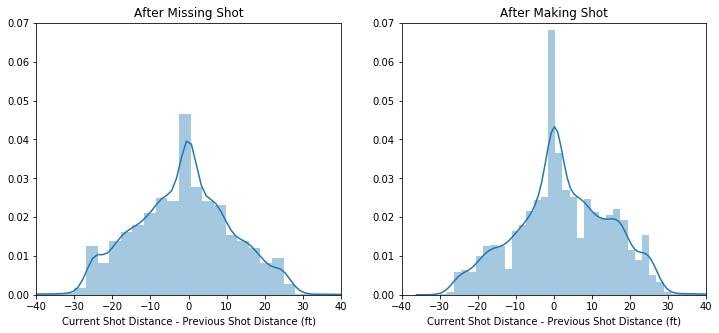

In [124]:
fig = plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title("After Missing Shot")
plt.xlabel("Current Shot Distance - Previous Shot Distance (ft)")
sns.distplot(dist_diff_after_missing).set(xlim=(-40, 40), ylim=(0, 0.07))
plt.subplot(122)
plt.title("After Making Shot")
plt.xlabel("Current Shot Distance - Previous Shot Distance (ft)")
sns.distplot(dist_diff_after_hitting).set(xlim=(-40, 40), ylim=(0, 0.07))

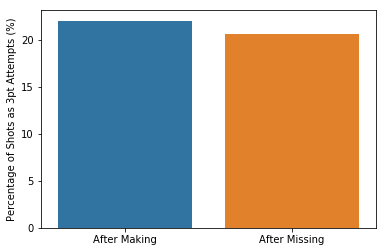

In [149]:
num_three_attempts_after_made_shot = sorted_games[(sorted_games.made_previous_shot == 1) & (
    sorted_games.shot_type == '3PT Field Goal')]['game_event_id'].count()
num_made_previous_shot = sorted_games[sorted_games.made_previous_shot == 1]['game_event_id'].count()
pct_after_made = num_three_attempts_after_made_shot * 100/num_made_previous_shot

num_three_attempts_after_missed_shot = sorted_games[(sorted_games.made_previous_shot == 0) & (
    sorted_games.shot_type == '3PT Field Goal')]['game_event_id'].count()
num_missed_previous_shot = sorted_games[sorted_games.made_previous_shot == 0]['game_event_id'].count()
pct_after_missed = num_three_attempts_after_missed_shot * 100/num_missed_previous_shot

ax = sns.barplot(['After Making', 'After Missing'], [pct_after_made, pct_after_missed])
ax.set(ylabel='Percentage of Shots as 3pt Attempts (%)')
plt.show()